<a href="https://colab.research.google.com/github/Shahbaz894/Generative-Ai-/blob/main/MultiModel_Rag_Base64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chroma multi-modal RAG
Many documents contain a mixture of content types, including text and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like GPT-4V, it is worth considering how to utilize images in RAG:

Option 1: (Shown)

Use multimodal embeddings (such as CLIP) to embed images and text
Retrieve both using similarity search
Pass raw images and text chunks to a multimodal LLM for answer synthesis
Option 2:

Use a multimodal LLM (such as GPT-4V, LLaVA, or FUYU-8b) to produce text summaries from images
Embed and retrieve text
Pass text chunks to an LLM for answer synthesis
Option 3

Use a multimodal LLM (such as GPT-4V, LLaVA, or FUYU-8b) to produce text summaries from images
Embed and retrieve image summaries with a reference to the raw image
Pass raw images and text chunks to a multimodal LLM for answer synthesis
This cookbook highlights Option 1:

We will use Unstructured to parse images, text, and tables from documents (PDFs).
We will use Open Clip multi-modal embeddings.
We will use Chroma with support for multi-modal.
A separate cookbook highlights Options 2 and 3 here.

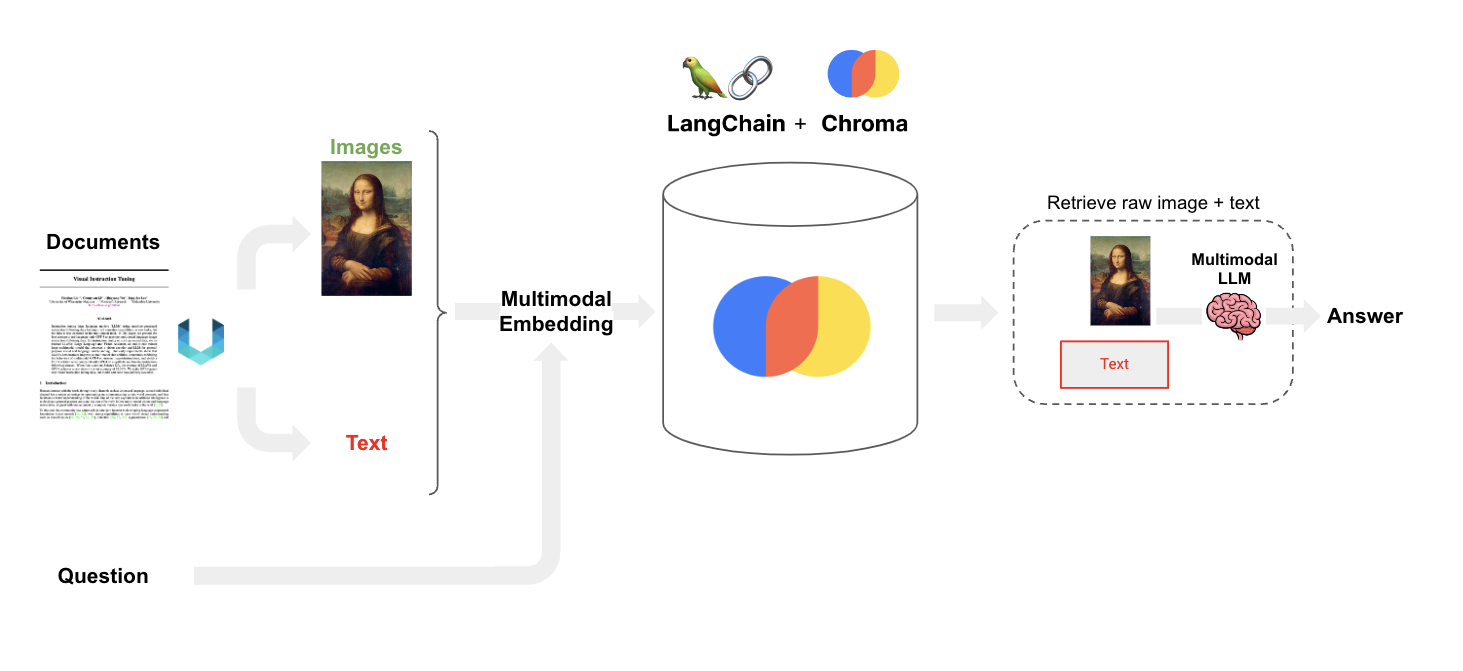

In [1]:
 !pip install transformers

In [2]:
!pip install unstructured-pytesseract

In [3]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 8.2 MB/s eta 0:00:00


In [4]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.49
    Uninstalling langchain-core-0.3.49:
      Successfully uninstalled langchain-core-0.3.49
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.7
    Uninstalling langchain-text-splitters-0.3.7:
      Successfully uninstalled langchain-text-splitters-0.3.7
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.22
    Uninstalling langchain-0.3.22:
      Successfully uninstalled langchain-0.3.22


In [5]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00

In [6]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,657 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [7]:
!sudo apt-get install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.3 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Fetched 3,743 kB in 2s (2,222 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dia

In [8]:

!sudo apt-get update


!sudo apt-get install poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,809 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [9]:
!sudo apt-get install libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libleptonica-dev is already the newest version (1.82.0-3build1).
libleptonica-dev set to manually installed.
libtesseract-dev is already the newest version (4.1.1-2.1build1).
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
tesseract-ocr-eng set to manually installed.
The following additional packages will be installed:
  libimagequant0 libraqm0 python3-olefile
Suggested packages:
  python-pil-doc
The following NEW packages will be installed:
  libimagequant0 libraqm0 python3-olefile python3-pil
  tesseract-ocr-script-latn
0 upgraded, 5 newly installed, 0 to remove and 44 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 91.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libimagequant0 amd64 2.17.0-1 [34.6 kB]
Get:2 http://archive.u

In [ ]:


!pip install unstructured-pytesseract
!pip install tesseract-ocr

  Preparing metadata (setup.py) ... done
  Created wheel for tesseract-ocr: filename=tesseract_ocr-0.0.1-cp311-cp311-linux_x86_64.whl size=179097 sha256=014283caed9e8036840576f3ce20335a0118caee724194aacde51ea815cc46a4
  Stored in directory: /root/.cache/pip/wheels/90/83/3c/d2b68d844d169d6015fc2ad8c93207d778829c87e26c6f2206
Successfully built tesseract-ocr


In [10]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [11]:
! pip install "unstructured[all-docs]" pillow pydantic lxml matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
!pip install langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


In [13]:
import torch

from unstructured.partition.pdf import partition_pdf

In [14]:
from google.colab import userdata
hf_token=userdata.get('HF_TOKEN')

In [15]:
from huggingface_hub import hf_hub_download



file_path = hf_hub_download(
    repo_id="unstructuredio/yolo_x_layout",
    filename="yolox_l0.05.onnx",
    token=hf_token
)

print("Model downloaded at:", file_path)


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

Model downloaded at: /root/.cache/huggingface/hub/models--unstructuredio--yolo_x_layout/snapshots/7680d6f857780bcf8d49916aa2e8881bd49dee3e/yolox_l0.05.onnx


In [16]:
from unstructured.partition.pdf import partition_pdf

raw_pdf_element = partition_pdf(
    filename='/content/sample_data/attention.pdf',
    strategy='hi_res',
    extract_images_in_pdf=True,
    extract_image_block_types=['Images', 'Table'],
    extract_image_block_to_payload=False,
    extract_image_block_output_dir='extracted_data',
    hi_res_model_path=file_path  # Set the model path manually
)



In [17]:
print(len(raw_pdf_element))

75


In [18]:
Header=[]
Footer=[]
Title=[]
NarrativeText=[]
Text=[]
ListItem=[]
Image=[]
Table=[]
for element in raw_pdf_element:
  if "unstructured.documents.elements.Header" in str(type(element)):
            Header.append(str(element))
  elif "unstructured.documents.elements.Footer" in str(type(element)):
            Footer.append(str(element))
  elif "unstructured.documents.elements.Title" in str(type(element)):
            Title.append(str(element))
  elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
            NarrativeText.append(str(element))
  elif "unstructured.documents.elements.Text" in str(type(element)):
            Text.append(str(element))
  elif "unstructured.documents.elements.ListItem" in str(type(element)):
            ListItem.append(str(element))
  elif "unstructured.documents.elements.Image" in str(type(element)):
            Image.append(str(element))
  elif "unstructured.documents.elements.Table" in str(type(element)):
            Table.append(str(element))

In [19]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [20]:
import os
os.environ["GOOGLE_API_KEY"]=GOOGLE_API_KEY

In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [22]:
def load_model(model_name):
    if model_name == "gemini-pro":
        return ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    elif model_name == "gemini-1.5-flash":
        return ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    elif model_name == "embedding":
        return GoogleGenerativeAIEmbeddings(model="models/embedding-001")
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

In [23]:
model=load_model('gemini-1.5-flash')

In [24]:
model_text=load_model("gemini-pro")

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [26]:
prompt_text="""You are an assistant tasked with summarizing text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text elements. \
    Give a concise summary of the table or text that is well optimized for retrieval.text: {element} """

In [27]:
promt=ChatPromptTemplate.from_template(prompt_text)

In [28]:
from langchain_groq import ChatGroq

In [29]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

In [30]:
# groq_model=ChatGroq(model="qwen-2.5-32b",api_key=GROQ_API_KEY)

In [31]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=GROQ_API_KEY)

In [32]:
prompt=ChatPromptTemplate.from_template(prompt_text)

In [33]:
summarize_chain={"element": lambda x:x}|promt|groq_model|StrOutputParser()

In [34]:
# !pip install langchain
# !pip install transformers


In [35]:
text_summary=summarize_chain.batch(NarrativeText,{"max_concurrency": 2})

# Creating Summary of table

In [79]:
prompt_text = """You are an AI Assistant tasked with summarizing tables for retrieval. \
    These summaries will be embedded and used to retrieve the raw table elements. \
    Give a concise summary of the table that is well optimized for retrieval. Table:{element} """

In [81]:
prompt = ChatPromptTemplate.from_template(prompt_text)

In [82]:
summarize_chain = {"element": lambda x: x} | prompt | groq_model | StrOutputParser()

In [83]:
table_summaries = []

In [84]:
table_summaries = summarize_chain.batch(Table, {"max_concurrency": 3})

In [36]:
text_summary

['<think>\nOkay, so the user has given me a query where they want to summarize some text for retrieval purposes. The text they provided is "To ots". Hmm, that seems a bit unclear. Maybe it\'s a typo or an abbreviation. I should consider what "ots" could stand for. It might be an abbreviation for something like "OTS" which can mean different things depending on the context, like "Open Trading System" or "Off-The-Shelf." But without more context, it\'s hard to tell.\n\nI need to figure out the user\'s intent. They mentioned that the summaries will be embedded and used to retrieve raw text elements. So, they\'re probably working on some kind of information retrieval system or maybe a database where summaries act as keys or indices. The summaries need to be concise and optimized for retrieval, which means they should be clear, specific, and probably include relevant keywords.\n\nThe user might be an assistant or someone building a retrieval system. They might not have provided enough conte

In [37]:
type(NarrativeText)

list

In [38]:
len(NarrativeText)

18

In [39]:
print(text_summary[4])

<think>
Okay, so I need to summarize the given text for retrieval. The text provided is "leaned." Hmm, that's a single word. I'm not sure what the context is. Maybe it's part of a larger sentence or a table? Since it's just "leaned," I should think about what this word could relate to.

"Leaned" is the past tense of "lean," which can mean bending something or relying on something. In a table, maybe it's part of a column or a row. Perhaps it's a verb describing an action, or maybe an adjective describing a state. Without more context, it's a bit tricky.

I should create a summary that's concise and optimized for retrieval. Maybe I can mention that it's a verb and its meaning. That way, when someone searches for "leaned," the summary will help retrieve the relevant text. I should keep it short and clear.

So, the summary could be something like: "Leaned refers to the past tense of 'lean,' indicating bending or reliance." That covers the basic meaning and is concise enough for retrieval p

In [40]:
import re
clean_text = re.sub(r"<think>.*?</think>\s*", "", text_summary[4], flags=re.DOTALL)

In [41]:
clean_text

'The text "leaned" is summarized as the past tense of "lean," indicating an action of bending or reliance.'

# Summary Of Images

In [42]:
import base64
import os
from langchain_core.messages import AIMessage, HumanMessage

In [61]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [62]:
image_model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [63]:
image_model.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-e008e77d-710a-4ae7-b82e-a1023c64717f-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [64]:
def image_summarize(img_base64,prompt):
    chat = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {
                    "type": "text",
                     "text": prompt
                     }
                    ,
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

In [65]:
def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))


    return img_base64_list, image_summaries

In [66]:
fpath="/content/extracted_data"

In [67]:
img_base64_list, image_summaries=generate_img_summaries(fpath)

In [68]:
image_summaries

['pink handwritten text on black background: Encode And Decode',
 'Sequence-to-sequence (seq2seq) encoder-decoder neural network translating "Thank you" (English) to "Gracias" (Spanish).  Illustrates LSTM layers, context vectors, softmax layer, and attention mechanism.  Includes diagrams of network architecture and example training data.',
 'Hand-drawn diagrams illustrating an encoder-decoder seq2seq architecture and its problems, specifically focusing on handling sentences of varying lengths and the resulting impact on the bleu score.  The diagrams show the flow of information through the encoder and decoder, including embedding layers, softmax, and context vectors.',
 'Hand-drawn diagram of an encoder-decoder architecture for machine translation.  The encoder processes "Hello What\'s Up" and the decoder outputs "Gracias".  The diagram includes hidden states, context vector, and softmax layer.',
 'Diagram showing a recurrent neural network architecture.  Key elements include:  time st

In [69]:
image_summaries[0]

'pink handwritten text on black background: Encode And Decode'

In [70]:
!pip install -U langchain-community

In [71]:
import uuid
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [75]:
def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
  store=InMemoryStore()
  id_key="doc_id"

  retriever=MultiVectorRetriever(
      vectorstore=vectorstore,
      docstore=store,
      id_key=id_key,
  )

  def add_documents(retriever, doc_summaries, doc_contents):

      doc_ids = [str(uuid.uuid4()) for _ in doc_contents]

      summary_docs = [
              Document(page_content=summary, metadata={id_key: doc_ids[i]})

              for i, summary in enumerate(doc_summaries)
          ]

      retriever.vectorstore.add_documents(summary_docs)
      retriever.docstore.mset(list(zip(doc_ids, doc_contents)))


  if text_summaries:
        add_documents(retriever, text_summaries, texts)
  if table_summaries:
        add_documents(retriever, table_summaries, tables)
  if image_summaries:
        add_documents(retriever, image_summaries, images)

  return retriever



In [76]:
embedding_model=load_model("embedding")

In [77]:
vectorstore=Chroma(collection_name="MMRAG",embedding_function=embedding_model)

In [86]:
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summary,
    NarrativeText,
    table_summaries,
    Table,
    image_summaries,
    img_base64_list,
)

In [87]:
retriever_multi_vector_img

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7a46f12830d0>, docstore=<langchain_core.stores.InMemoryStore object at 0x7a46f73d6850>, search_kwargs={})

In [88]:
query = "Why We combine a pre-trained retriever (Query Encoder + Document Index) with a pre-trained seq2seq model (Generator) and fine-tune end-to-end?"

In [89]:
retriever_multi_vector_img.get_relevant_documents(query)

<ipython-input-89-3e2ed09adac7>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever_multi_vector_img.get_relevant_documents(query)


['Generates the output word-by-word, and keeps feeding the previous word into the decoder again States get passed through —-> DECODER',
 'put seq with S the i-th word of the input se 0 annotations are com- puted in the next sect',
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAZFBhEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsP

In [90]:
retriever_multi_vector_img.invoke(query)

['Generates the output word-by-word, and keeps feeding the previous word into the decoder again States get passed through —-> DECODER',
 'put seq with S the i-th word of the input se 0 annotations are com- puted in the next sect',
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAZFBhEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsP

# image data processing

In [91]:
import io
import re
from IPython.display import HTML, display
from PIL import Image

In [92]:
def is_image_data(b64data):
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

In [93]:
def resize_base64_image(base64_string,size=(128,128)):
  # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")



In [101]:
def looks_like_base64(sb):
  return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

In [102]:
def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []

    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)

    return {"images": b64_images, "texts": texts}


In [103]:
def img_prompt_func(data_dict):
  """
  Join the context into a single string
  """
  print(data_dict)
  formatted_texts = "\n".join(data_dict["context"]["texts"])
  messages = []

  # Adding image(s) to the messages if present
  if data_dict["context"]["images"]:
      for image in data_dict["context"]["images"]:
          image_message = {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{image}"},
          }
          messages.append(image_message)

  # Adding the text for analysis
  text_message = {
      "type": "text",
      "text": (
          "You are a helpful assistant.\n"
          "You will be given a mixed info(s) .\n"
          "Use this information to provide relevant information to the user question. \n"
          f"User-provided question: {data_dict['question']}\n\n"
          "Text and / or tables:\n"
          f"{formatted_texts}"
      ),
  }
  messages.append(text_message)
  return [HumanMessage(content=messages)]

In [104]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [105]:
def multi_modal_rag_chain(retriever):
  chain=(
      {"context":retriever | RunnableLambda(split_image_text_types),
       "question": RunnablePassthrough()
      }
      | RunnableLambda(img_prompt_func)

      |model
      |StrOutputParser()
  )

  return chain

In [106]:
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [107]:
query1="Explain any images / figures in the paper with Left: NQ performance as more documents are retrieved. Center: Retrieval recall performance\
in NQ. Right: MS-MARCO Bleu-1 and Rouge-L as more documents are retrieved."

In [108]:
chain_multimodal_rag.invoke(query1)

{'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJYBRQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDy3WP+Qdo3/Xq3/oZrKYEYz6Vq6x/yDtG/69W/9DNZRAHcH6UF1NxKVgQeev1pKUjBwCD9KCBB1pWBBIPWkpSMHAOfcUAAySAOtIc5OetAGT1A+tGMcUAKAScDrSUAZOMge5ooAVQScDr9cUl

'The provided text mentions a decoder that generates output word-by-word, feeding the previous word back into itself.  This description is consistent with an autoregressive sequence-to-sequence model, often used in machine translation and text generation.  The images you provided show diagrams of various encoder-decoder architectures, illustrating how these models work.\n\nHowever, there is no information in your provided text or images that relates to the "NQ performance," "retrieval recall performance in NQ," "MS-MARCO Bleu-1," or "Rouge-L" metrics.  The images depict the internal workings of neural networks for sequence-to-sequence tasks, but they don\'t show any performance results or graphs.  To explain the figures you mentioned, I need the actual figures. Please provide them.'